In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

FULL_PAGE_WIDTH = 7.2

sns.set_theme(context="paper", font_scale=1.5, style="whitegrid", palette="Set2")

In [44]:
import pandas as pd
from pathlib import Path

PLOT_OUTPUT_DIR = Path("./plots")

def format_seconds(x: float) -> str:
    return r"\SI{" f"{x:0.02f}" r"}{\second}"

fits_df = pd.read_csv("./measure_latency/results/fits.csv")

print(
    pd.DataFrame(fits_df)
    .to_latex(
        index=False,
        formatters={
            "mean": format_seconds,
            "jitter": lambda x: r"$ \pm " + format_seconds(x) + " $",
            "shape": lambda x: r"\num{" f"{x:0.02f}" r"}",
            "scale": format_seconds,
        }
    )
)    

\begin{tabular}{rrrr}
\toprule
mean & jitter & shape & scale \\
\midrule
\SI{0.10}{\second} & $ \pm \SI{0.02}{\second} $ & \num{4.50} & \SI{0.09}{\second} \\
\SI{0.20}{\second} & $ \pm \SI{0.04}{\second} $ & \num{6.26} & \SI{0.18}{\second} \\
\SI{0.40}{\second} & $ \pm \SI{0.08}{\second} $ & \num{6.84} & \SI{0.35}{\second} \\
\SI{0.80}{\second} & $ \pm \SI{0.16}{\second} $ & \num{7.75} & \SI{0.70}{\second} \\
\SI{1.60}{\second} & $ \pm \SI{0.32}{\second} $ & \num{7.69} & \SI{1.39}{\second} \\
\SI{3.20}{\second} & $ \pm \SI{0.64}{\second} $ & \num{7.59} & \SI{2.78}{\second} \\
\bottomrule
\end{tabular}



In [45]:
experiment_cats = pd.CategoricalDtype(["packet", "frame", "step"], ordered=True)
model_mapping = {
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "3rd-poly-low": "3rd Order Poly. (low neuroticism)",  # multi-curve always fits 3rd
    "3rd-poly-high": "3rd Order Poly. (high neuroticism)",
    "legacy": "EdgeDroid"
}

model_cats = pd.CategoricalDtype([
    "EdgeDroid",
    "Ref. Stochastic",
    "Ref. Median",
    "3rd Order Poly. (low neuroticism)",
    "3rd Order Poly. (high neuroticism)",
], ordered=True)

step_frame_data = pd.read_csv('per_frame_step_delay_new_pareto_params.csv')
step_frame_data["model"] = step_frame_data["model"].replace(model_mapping).astype(model_cats)
step_frame_data["mean/jitter"] = step_frame_data[["latency_mean", "latency_jitter"]].apply(lambda row: r"$ " f"{row.latency_mean:01.2f}" r" \pm " f"{row.latency_jitter:01.2f}" r" $", axis=1)
for col in ["latency_rho", "latency_mean", "latency_jitter", "pareto_shape", "pareto_scale", "mean/jitter"]:
    step_frame_data[col] = step_frame_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
    
step_frame_data["experiment"] = step_frame_data["experiment"].astype(experiment_cats)

step_frame_data["task_duration"] = step_frame_data.groupby([
    "experiment", "model", "latency_rho", "mean/jitter", 
    "latency_mean", "latency_jitter", "pareto_shape", "pareto_scale", 
    "rep"], observed=True)["step_duration"].cumsum()
step_frame_data.groupby(["experiment", "model", "latency_rho", "mean/jitter", "pareto_scale", "pareto_scale"], observed=True).count()

step_number  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                
frame      EdgeDroid                          0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346             1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206             1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322             1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636             1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286             1530   
...                                                                                                            ...   
step       3rd Order Poly. (high neuroticism) 0.5         $ 0.20 \pm 0.04 $ 0.177206     0.177206             1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322             1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636             1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286             1530   
                                                          $ 3.20 \pm 0.64 $ 2.783705     2.783705             1530   

                                                                                                       last_frame_rtt  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                   
frame      EdgeDroid                          0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346                1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
...                                                                                                               ...   
step       3rd Order Poly. (high neuroticism) 0.5         $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
                                                          $ 3.20 \pm 0.64 $ 2.783705     2.783705                1530   

                                                                                                       execution_time  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                   
frame      EdgeDroid                          0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346                1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
...                                                                                                               ...   
step       3rd Order Poly.

In [46]:
packet_data = pd.read_csv('./per_packet_delay.csv').drop(columns=["lat_var"])
packet_data[["latency_mean", "latency_jitter"]] = packet_data[["one_way_latency", "one_way_variance"]] * 2 / 1000.0
packet_data["latency_rho"] = packet_data["one_way_corr"] / 100.0
packet_data["mean/jitter"] = packet_data[["latency_mean", "latency_jitter"]].apply(lambda row: r"$ " f"{row.latency_mean:01.2f}" r" \pm " f"{row.latency_jitter:01.2f}" r" $", axis=1)
packet_data["experiment"] = "packet"

for col in ["latency_rho", "mean/jitter", "latency_mean", "latency_jitter"]:
    packet_data[col] = packet_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
packet_data["experiment"] = packet_data["experiment"].astype(experiment_cats)
packet_data["model"] = packet_data["model"].replace({"Legacy EdgeDroid 1.0": "EdgeDroid"})
packet_data["model"] = packet_data["model"].astype(model_cats)

# packet_data["mean/var"] = 
packet_data = packet_data[[
    "experiment", "model", "latency_rho", "latency_mean", "latency_jitter", "mean/jitter", "rep",
    "step_number", "execution_time", "step_duration", "time_to_feedback", "wait_time", "frame_count", "task_duration",
]]
packet_data

,experiment,model,latency_rho,latency_mean,latency_jitter,mean/jitter,rep,step_number,execution_time,step_duration,time_to_feedback,wait_time,frame_count,task_duration
0,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,0,0.000000,1.312022,1.312022,0.001056,1,1.312022
1,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,1,5.230947,5.898414,0.667467,0.047629,19,7.210436
2,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,2,5.230947,6.152435,0.921487,0.244008,13,13.362871
3,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,3,5.230947,5.994312,0.763365,0.171086,11,19.357183
4,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,4,5.230947,6.094443,0.863496,0.278195,13,25.451626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,packet,EdgeDroid,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,46,4.049000,4.595999,0.546999,0.032667,15,215.104562
45896,packet,EdgeDroid,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,47,4.049000,4.824017,0.775017,0.253439,16,219.928579
45897,packet,EdgeDroid,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,48,4.049000,4.605951,0.556951,0.057825,16,224.534530
45898,packet,EdgeDroid,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,49,4.049000,4.713981,0.664981,0.116904,14,229.248511


In [47]:
data = pd.concat([
    step_frame_data,
    packet_data
])
data["experiment"] = data["experiment"].astype(pd.CategoricalDtype(["packet", "frame", "step"], ordered=True))
data.groupby(["experiment", "mean/jitter", "latency_rho", "model"], observed=True).count()

step_number  \
experiment mean/jitter       latency_rho model                                             
packet     $ 0.10 \pm 0.02 $ 0.0         EdgeDroid                                   510   
                                         Ref. Stochastic                             510   
                                         Ref. Median                                 510   
                                         3rd Order Poly. (low neuroticism)           510   
                                         3rd Order Poly. (high neuroticism)          510   
...                                                                                  ...   
step       $ 3.20 \pm 0.64 $ 0.5         EdgeDroid                                  1530   
                                         Ref. Stochastic                            1530   
                                         Ref. Median                                1530   
                                         3rd Order Poly. (low neuroticism)          1530   
                                         3rd Order Poly. (high neuroticism)         1530   

                                                                             last_frame_rtt  \
experiment mean/jitter       latency_rho model                                                
packet     $ 0.10 \pm 0.02 $ 0.0         EdgeDroid                                        0   
                                         Ref. Stochastic                                  0   
                                         Ref. Median                                      0   
                                         3rd Order Poly. (low neuroticism)                0   
                                         3rd Order Poly. (high neuroticism)               0   
...                                                                                     ...   
step       $ 3.20 \pm 0.64 $ 0.5         EdgeDroid                                     1530   
                                         Ref. Stochastic                               1530   
                                         Ref. Median                                   1530   
                                         3rd Order Poly. (low neuroticism)             1530   
                                         3rd Order Poly. (high neuroticism)            1530   

                                                                             execution_time  \
experiment mean/jitter       latency_rho model                                                
packet     $ 0.10 \pm 0.02 $ 0.0         EdgeDroid                                      510   
                                         Ref. Stochastic                                510   
                                         Ref. Median                                    510   
                                         3rd Order Poly. (low neuroticism)              510   
                                         3rd Order Poly. (high neuroticism)             510   
...                                                                                     ...   
step       $ 3.20 \pm 0.64 $ 0.5         EdgeDroid                                     1530   
                                         Ref. Stochastic                               1530   
                                         Ref. Median                                   1530   
                                         3rd Order Poly. (low neuroticism)             1530   
                                         3rd Order Poly. (high neuroticism)            1530   

                                                                             step_duration  \
experiment mean/jitter       latency_rho model                                               
packet     $ 0.10 \pm 0.02 $ 0.0         EdgeDroid                                     510   
                                         Ref. Stochastic                               510   
                                

In [48]:
task_duration_data = data.groupby(["experiment", "model", "mean/jitter", "latency_rho", "latency_mean", "latency_jitter", "rep"], observed=True)["step_duration"].sum().reset_index()
task_duration_data = task_duration_data.rename(columns={"step_duration": "task_duration"})
task_duration_data

,experiment,model,mean/jitter,latency_rho,latency_mean,latency_jitter,rep,task_duration
0,packet,EdgeDroid,$ 0.10 \pm 0.02 $,0.0,0.1,0.02,1,237.728679
1,packet,EdgeDroid,$ 0.10 \pm 0.02 $,0.0,0.1,0.02,2,232.647041
2,packet,EdgeDroid,$ 0.10 \pm 0.02 $,0.0,0.1,0.02,3,232.358561
3,packet,EdgeDroid,$ 0.10 \pm 0.02 $,0.0,0.1,0.02,4,233.835657
4,packet,EdgeDroid,$ 0.10 \pm 0.02 $,0.0,0.1,0.02,5,233.877545
...,...,...,...,...,...,...,...,...
6295,step,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,0.5,3.2,0.64,25,558.001772
6296,step,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,0.5,3.2,0.64,26,581.279325
6297,step,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,0.5,3.2,0.64,27,573.139101
6298,step,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,0.5,3.2,0.64,28,561.476241


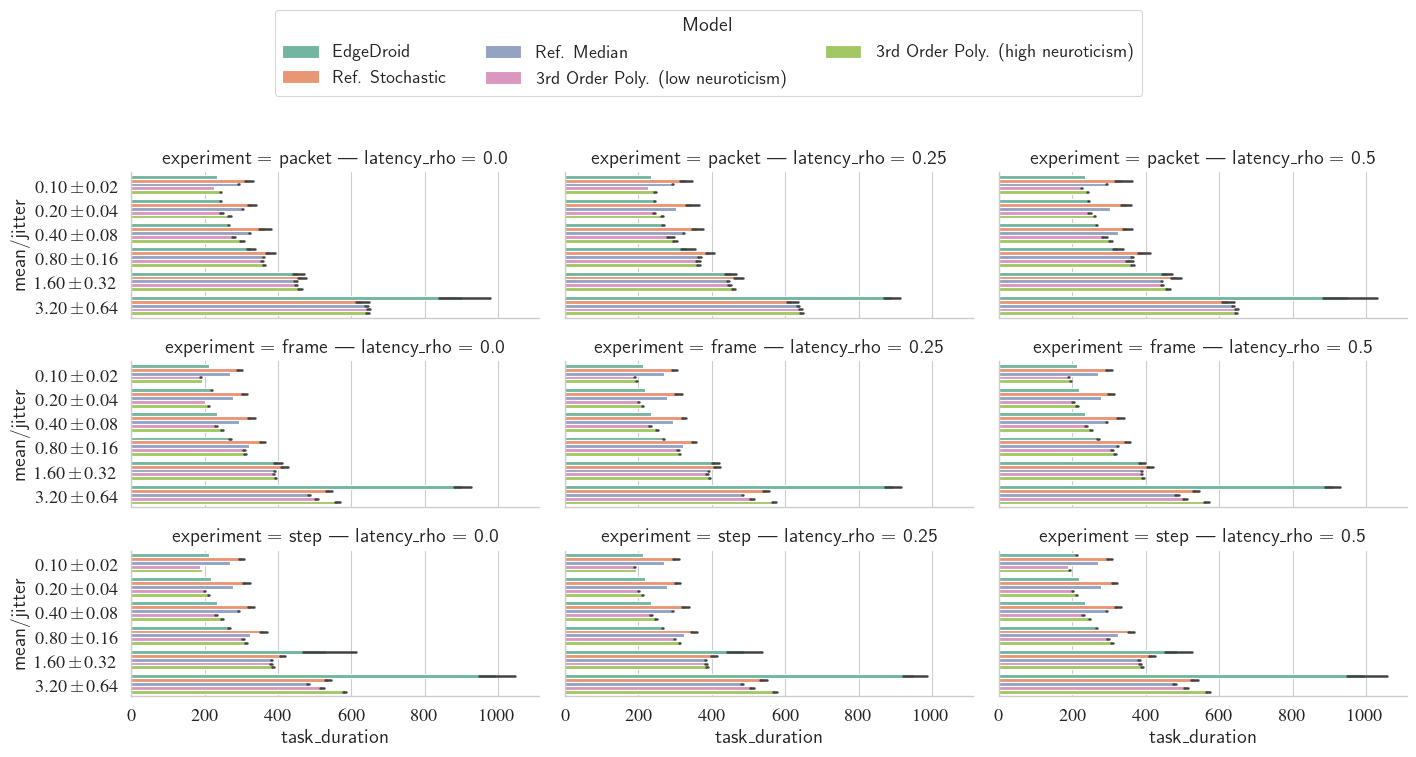

In [49]:
fg = sns.catplot(data=task_duration_data, kind="bar", x="task_duration", y="mean/jitter", hue="model", col="latency_rho", row="experiment", legend_out=False)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#     ax.yaxis.grid(True, which="minor")
#     ax.yaxis.grid(True, which="major")
#     ax.xaxis.grid(True)

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=3)
fg.figure.set_size_inches((2*FULL_PAGE_WIDTH, 2*3.2))
fg.tight_layout()
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_43925/22772237.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="mean/jitter", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


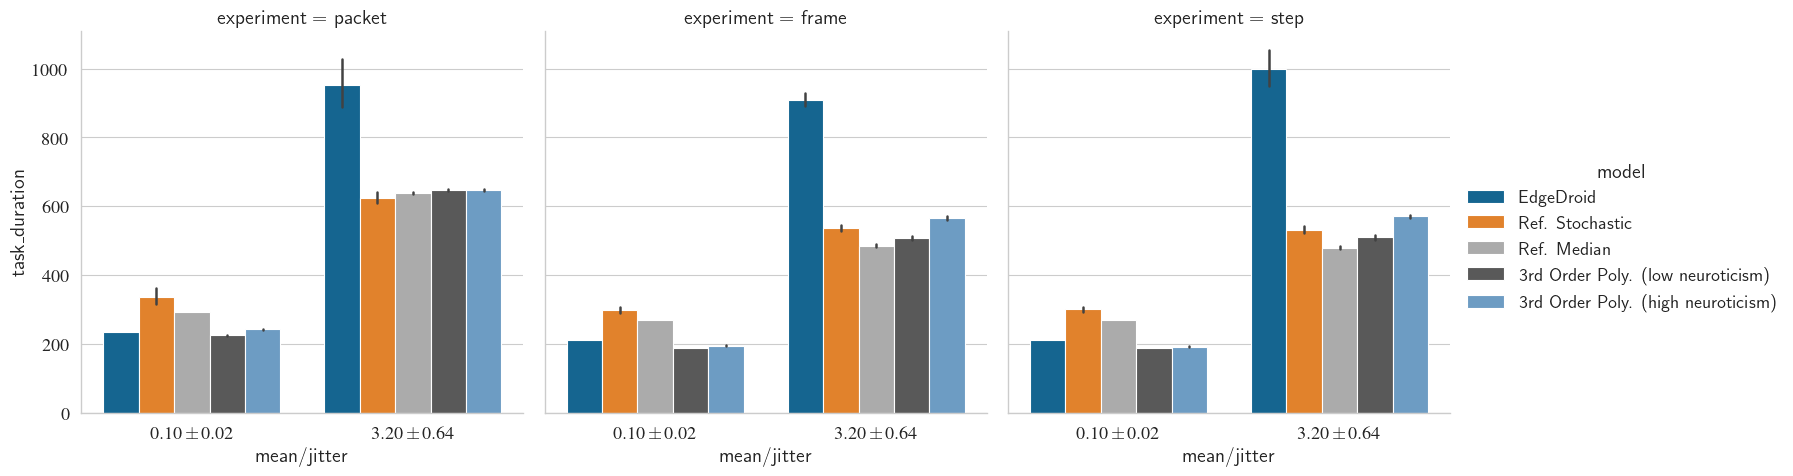

In [50]:
import numpy as np
from pypalettes import load_cmap

comp_data = task_duration_data[
    (task_duration_data.latency_rho == 0.5) 
    & np.isin(task_duration_data.latency_mean, (0.10, 3.20))
    & np.isin(task_duration_data.latency_jitter, (0.02, 0.64))
].copy()
comp_data["mean/jitter"] = comp_data["mean/jitter"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="mean/jitter", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()



/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_43925/2355337130.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


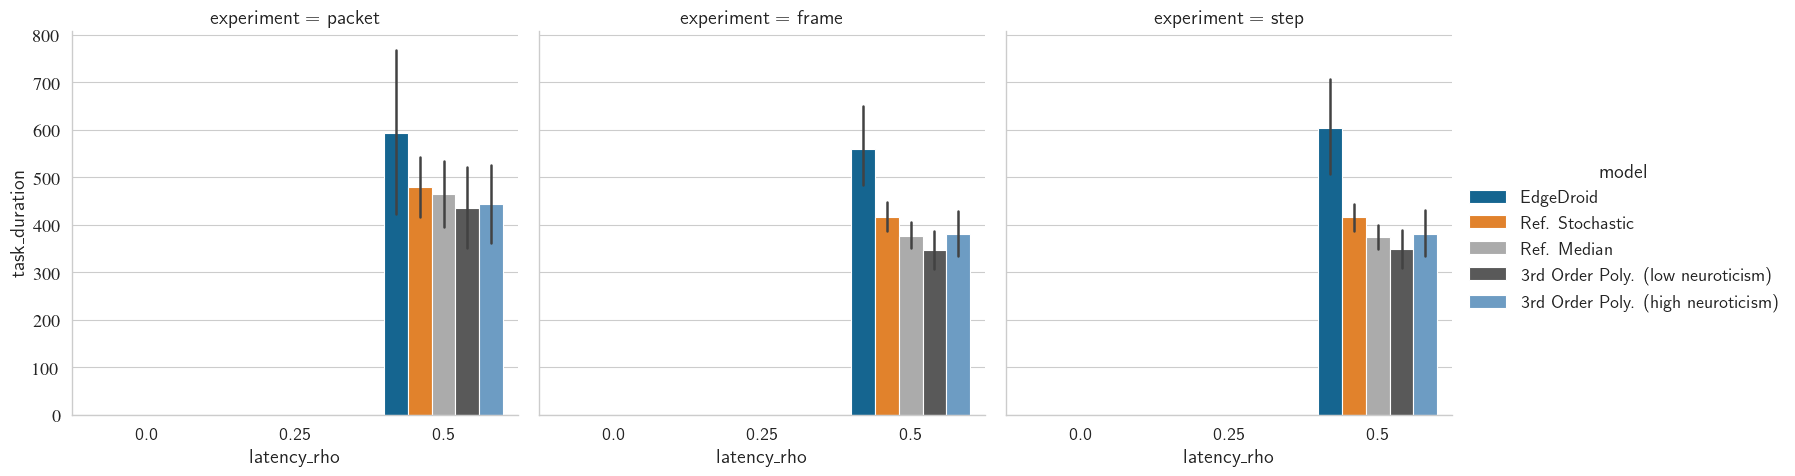

In [51]:
fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_43925/887749227.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", row="mean/jitter", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


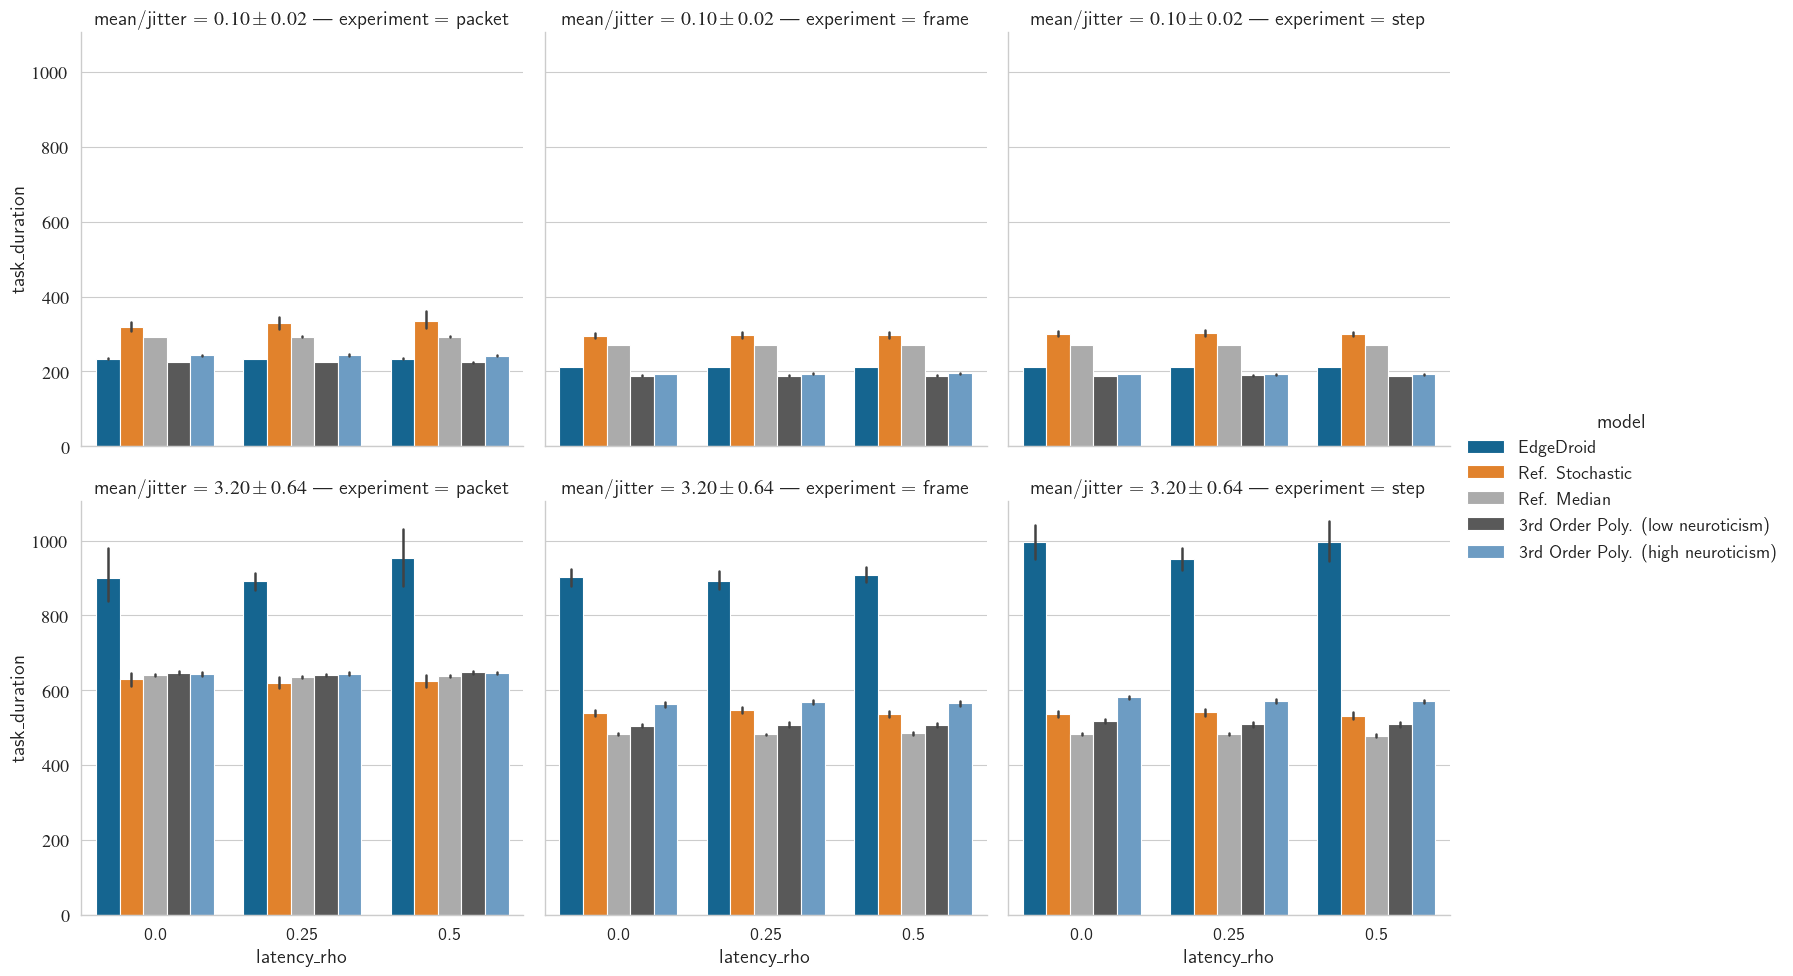

In [52]:
comp_data = task_duration_data[
            np.isin(task_duration_data.latency_mean, (0.10, 3.20))
            & np.isin(task_duration_data.latency_jitter, (0.02, 0.64))].copy()
comp_data["mean/jitter"] = comp_data["mean/jitter"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", row="mean/jitter", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

# Paper plots

Experiment packet


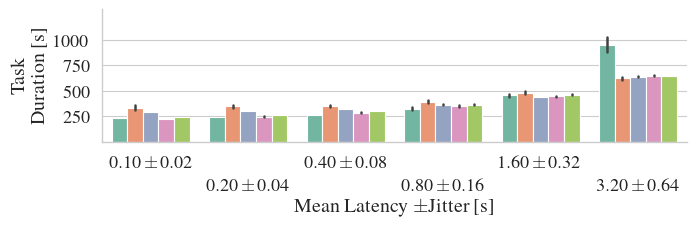

mean/jitter        model                             
$ 0.10 \pm 0.02 $  EdgeDroid                             234.011113
                   Ref. Stochastic                       328.237477
                   Ref. Median                           292.915692
                   3rd Order Poly. (low neuroticism)     225.186518
                   3rd Order Poly. (high neuroticism)    243.075922
$ 0.20 \pm 0.04 $  EdgeDroid                             243.953834
                   Ref. Stochastic                       341.302188
                   Ref. Median                           302.717555
                   3rd Order Poly. (low neuroticism)     245.008595
                   3rd Order Poly. (high neuroticism)    263.496102
$ 0.40 \pm 0.08 $  EdgeDroid                             265.540571
                   Ref. Stochastic                       357.863003
                   Ref. Median                           323.709594
                   3rd Order Poly. (low neuroticism)     284.3

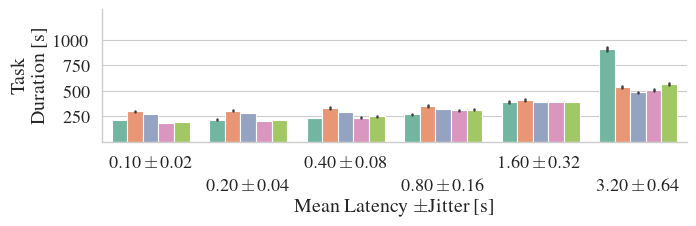

mean/jitter        model                             
$ 0.10 \pm 0.02 $  EdgeDroid                             211.470369
                   Ref. Stochastic                       297.001100
                   Ref. Median                           270.562585
                   3rd Order Poly. (low neuroticism)     188.817219
                   3rd Order Poly. (high neuroticism)    193.820928
$ 0.20 \pm 0.04 $  EdgeDroid                             218.839905
                   Ref. Stochastic                       306.890332
                   Ref. Median                           277.925872
                   3rd Order Poly. (low neuroticism)     200.635994
                   3rd Order Poly. (high neuroticism)    211.960216
$ 0.40 \pm 0.08 $  EdgeDroid                             234.370252
                   Ref. Stochastic                       327.318415
                   Ref. Median                           293.386254
                   3rd Order Poly. (low neuroticism)     232.8

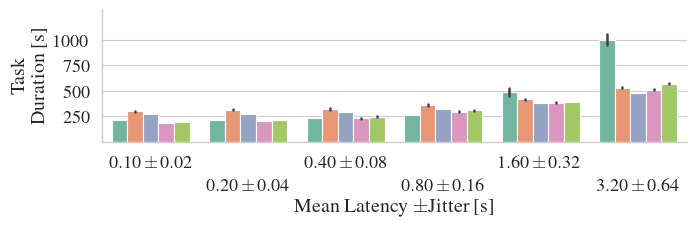

mean/jitter        model                             
$ 0.10 \pm 0.02 $  EdgeDroid                             211.125421
                   Ref. Stochastic                       301.408502
                   Ref. Median                           270.194279
                   3rd Order Poly. (low neuroticism)     188.452928
                   3rd Order Poly. (high neuroticism)    192.529463
$ 0.20 \pm 0.04 $  EdgeDroid                             218.483212
                   Ref. Stochastic                       311.716598
                   Ref. Median                           277.613447
                   3rd Order Poly. (low neuroticism)     200.276965
                   3rd Order Poly. (high neuroticism)    210.604164
$ 0.40 \pm 0.08 $  EdgeDroid                             233.991827
                   Ref. Stochastic                       326.460652
                   Ref. Median                           292.576369
                   3rd Order Poly. (low neuroticism)     231.2

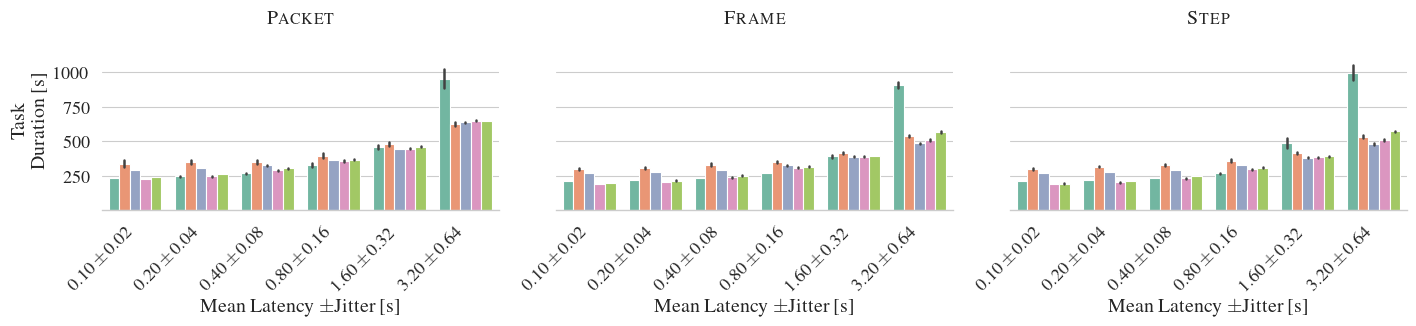

In [53]:
y_axis_max = 1300
yticks=(250, 500, 750, 1000)

task_duration_data["experiment_caps"] = task_duration_data["experiment"].apply(lambda x: r"\textsc{" f"{x.capitalize()}" r"}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times",
    "font.sans-serif": "Computer Modern",
})

for (experiment,), df in task_duration_data.groupby(["experiment"], observed=True):
    print(f"Experiment {experiment}")
    fg = sns.catplot(
        data=df[df["latency_rho"] == 0.5], 
        kind="bar", 
        x="mean/jitter", 
        y="task_duration", 
        hue="model",
        legend_out=False,
        legend=False,
        dodge=True,
    )
    for ax in fg.axes.flat:
        # ax.tick_params(axis="x", reset=True, top=False)
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)
        # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.yaxis.grid(True, which="both")
        ax.xaxis.grid(False)
    
    fg.set(ylim=(0, y_axis_max), yticks=yticks)
    fg.set_axis_labels(r"Mean Latency $ \pm $Jitter [s]", "Task\nDuration [s]")
    # fg.legend.set_title("Model")
    fg.fig.set_size_inches(2*FULL_PAGE_WIDTH/2, 2.5)
    # fg.fig.suptitle(f"Experiment: {experiment} | Autocorrelation: 50%")
    fg.fig.tight_layout()
    fg.fig.savefig(PLOT_OUTPUT_DIR / f"{experiment}_task_durations_50pcnt_autocorr.pdf", dpi=500, bbox_inches='tight')
    plt.show()
    
    print(df.groupby(["mean/jitter", "model"], observed=True)["task_duration"].mean())
    

fg = sns.catplot(
    data=task_duration_data[task_duration_data["latency_rho"] == 0.5], 
    kind="bar",
    x="mean/jitter",
    y="task_duration",
    hue="model",
    col="experiment_caps",
    # legend_out=False,
    legend=False,
    dodge=True,
)
for ax in fg.axes.flat:
    # ax.tick_params(axis="x", reset=True, top=False)
    # for tick in ax.xaxis.get_major_ticks()[1::2]:
        # tick.set_pad(20)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="both")
    ax.xaxis.grid(False)

fg.set_titles(col_template="{col_name}")
sns.despine(fg.fig, left=True)
fg.set(ylim=(0, y_axis_max), yticks=yticks)
fg.set_axis_labels(r"Mean Latency $ \pm $Jitter [s]", "Task\nDuration [s]")
# fg.legend.set_title("Model")
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 3.5)
# fg.fig.suptitle(f"Experiment: {experiment} | Autocorrelation: 50%")
fg.fig.tight_layout()
fg.fig.savefig(PLOT_OUTPUT_DIR / f"task_durations_50pcnt_autocorr.pdf", dpi=500, bbox_inches='tight')
plt.show()

In [54]:
def cross_difference_durations(df: pd.DataFrame) -> pd.DataFrame:
    realistic_df = df[np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    reference_df = df[~np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    
    cross_df = pd.merge(
        reference_df[["model", "task_duration"]],
        realistic_df[["model", "task_duration"]],
        suffixes=("_reference", "_realistic"),
        how="cross",
    )
    cross_df["task_duration_reldiff"] = (cross_df["task_duration_reference"] - cross_df["task_duration_realistic"]) / cross_df["task_duration_realistic"]
    return cross_df[["model_reference", "model_realistic", "task_duration_reldiff"]]
    
    
    
reldiff_data = task_duration_data.groupby(["experiment", "experiment_caps", "latency_mean", "latency_jitter", "mean/jitter", "latency_rho"], observed=True).apply(cross_difference_durations, include_groups=False).reset_index().drop(columns=["level_6"])
reldiff_data["label"] = reldiff_data[["model_reference", "model_realistic"]].apply(lambda row: f"{row.model_reference} | {'High Neuroticism' if 'high' in row.model_realistic else 'Low Neuroticism'}", axis=1)
reldiff_data

,experiment,experiment_caps,latency_mean,latency_jitter,mean/jitter,latency_rho,model_reference,model_realistic,task_duration_reldiff,label
0,packet,\textsc{Packet},0.1,0.02,$ 0.10 \pm 0.02 $,0.0,EdgeDroid,3rd Order Poly. (low neuroticism),0.058832,EdgeDroid | Low Neuroticism
1,packet,\textsc{Packet},0.1,0.02,$ 0.10 \pm 0.02 $,0.0,EdgeDroid,3rd Order Poly. (low neuroticism),0.056319,EdgeDroid | Low Neuroticism
2,packet,\textsc{Packet},0.1,0.02,$ 0.10 \pm 0.02 $,0.0,EdgeDroid,3rd Order Poly. (low neuroticism),0.042654,EdgeDroid | Low Neuroticism
3,packet,\textsc{Packet},0.1,0.02,$ 0.10 \pm 0.02 $,0.0,EdgeDroid,3rd Order Poly. (low neuroticism),0.058168,EdgeDroid | Low Neuroticism
4,packet,\textsc{Packet},0.1,0.02,$ 0.10 \pm 0.02 $,0.0,EdgeDroid,3rd Order Poly. (low neuroticism),0.061299,EdgeDroid | Low Neuroticism
...,...,...,...,...,...,...,...,...,...,...
205195,step,\textsc{Step},3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Median,3rd Order Poly. (high neuroticism),-0.113255,Ref. Median | High Neuroticism
205196,step,\textsc{Step},3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Median,3rd Order Poly. (high neuroticism),-0.148765,Ref. Median | High Neuroticism
205197,step,\textsc{Step},3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Median,3rd Order Poly. (high neuroticism),-0.136675,Ref. Median | High Neuroticism
205198,step,\textsc{Step},3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Median,3rd Order Poly. (high neuroticism),-0.118743,Ref. Median | High Neuroticism


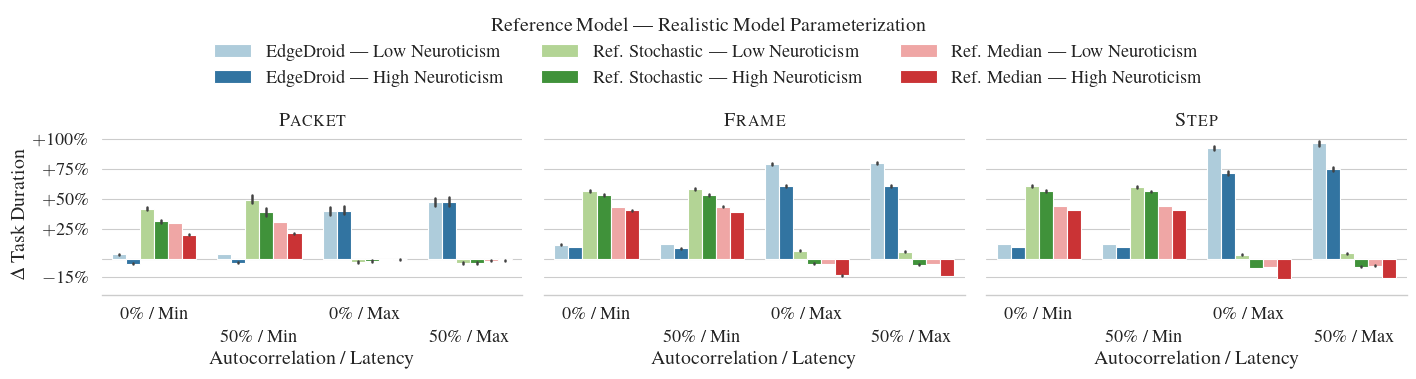

experiment  label                               rho/latency   
packet      EdgeDroid | High Neuroticism        $ 0 \%$ / Max     0.401173
                                                $ 0 \%$ / Min    -0.039699
                                                $ 50 \%$ / Max    0.473774
                                                $ 50 \%$ / Min   -0.032080
            EdgeDroid | Low Neuroticism         $ 0 \%$ / Max     0.393933
                                                                    ...   
step        Ref. Stochastic | High Neuroticism  $ 50 \%$ / Min    0.560620
            Ref. Stochastic | Low Neuroticism   $ 0 \%$ / Max     0.034772
                                                $ 0 \%$ / Min     0.603259
                                                $ 50 \%$ / Max    0.046520
                                                $ 50 \%$ / Min    0.598844
Name: task_duration_reldiff, Length: 72, dtype: float64

In [55]:
# plot_data = reldiff_data[reldiff_data["model_reference"] != "Legacy EdgeDroid 1.0"].copy()
plot_data = reldiff_data.copy()
plot_data = plot_data[
    np.isin(plot_data["latency_rho"], (0.0, 0.5))
    & np.isin(plot_data.latency_mean, (0.10, 3.20))
    & np.isin(plot_data.latency_jitter, (0.02, 0.64))
]
for col in ("mean/jitter", "model_reference", "latency_rho"):
    plot_data[col] = plot_data[col].cat.remove_unused_categories()

plot_data["rho_pcnt"] = plot_data["latency_rho"].apply(lambda r: r"$ " f"{r * 100.0:.0f}" r" \%$")
plot_data["latency_tag"] = plot_data["mean/jitter"].apply(lambda t: "Min" if "0.10" in t else "Max").astype(pd.CategoricalDtype(("Min", "Max"), ordered=True))
plot_data["rho/latency"] = plot_data[["rho_pcnt", "latency_tag"]].apply(lambda row: " / ".join([str(x) for x in row]), axis=1)

fg = sns.catplot(data=plot_data, kind="bar", hue="label", x="rho/latency", y="task_duration_reldiff", col="experiment_caps", palette="Paired")
sns.despine(fig=fg.fig, left=True)
for ax in fg.axes.flat:
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="both")
    # ax.yaxis.grid(True, which="major")
    # ax.xaxis.grid(True)
    # ax.yaxis.set_major_formatter(lambda x, p: r"$" f"{x * 100:+.0f}" r"\% $")

fg.set_axis_labels(r"Autocorrelation / Latency", r"$ \Delta $ Task Duration")
fg.set(
    ylim=(-0.3, None), 
    yticks=(-0.15, 0.0, 0.25, 0.5, 0.75, 1.0), 
    yticklabels=(
        r"$" f"{-0.15 * 100:+.0f}" r"\% $",
        "",
        r"$" f"{0.25 * 100:+.0f}" r"\% $",
        r"$" f"{0.5 * 100:+.0f}" r"\% $",
        r"$" f"{0.75 * 100:+.0f}" r"\% $",
        r"$" f"{1 * 100:+.0f}" r"\% $")
)
fg.set_titles(col_template="{col_name}")
sns.move_legend(fg, "upper center", title="Reference Model | Realistic Model Parameterization", bbox_to_anchor=(.5, 1.3), ncols=3)
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 3)
fg.fig.tight_layout()
plt.savefig(PLOT_OUTPUT_DIR / "task_duration_diff.pdf", dpi=500, bbox_extra_artists=[fg.legend], bbox_inches='tight')
plt.show()

plot_data.groupby(["experiment", "label", "rho/latency"], observed=True)["task_duration_reldiff"].mean()

Experiment: packet


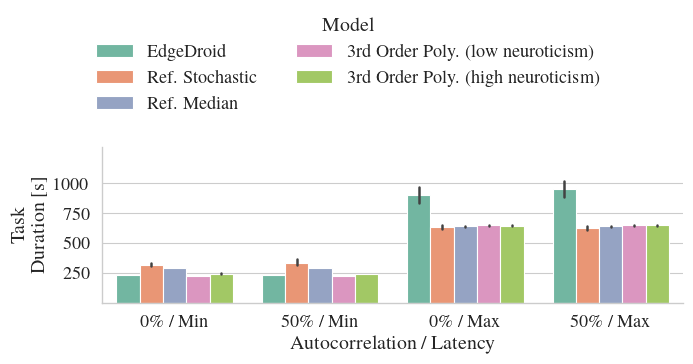

Experiment: frame


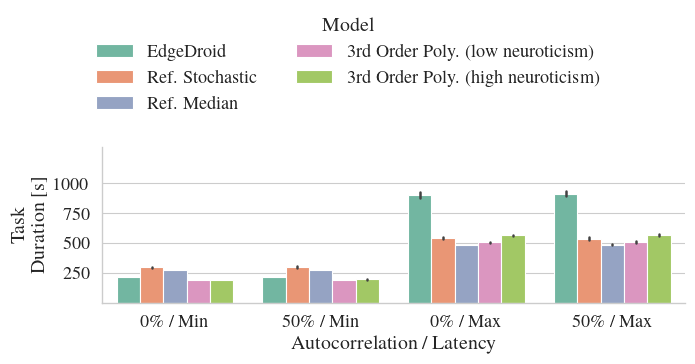

Experiment: step


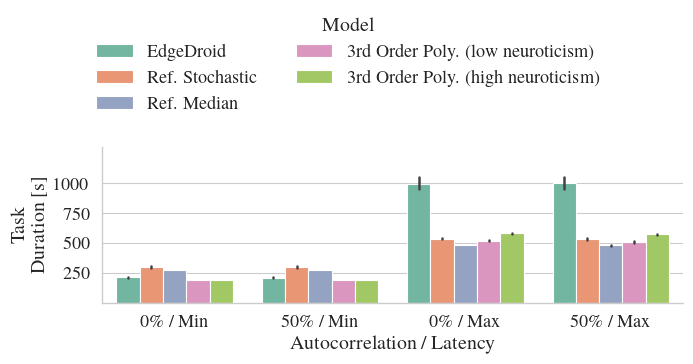

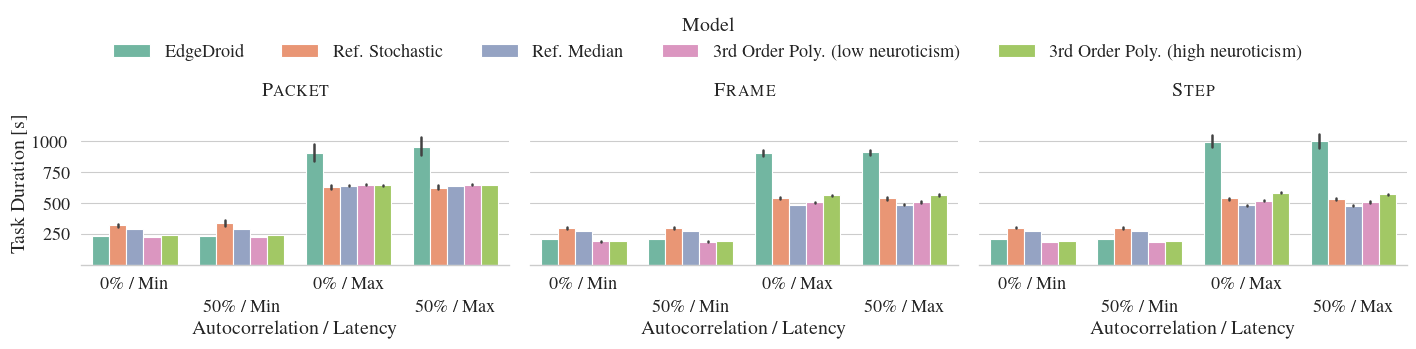

In [56]:
exp_comp_data = task_duration_data[
    np.isin(task_duration_data["latency_rho"], (0.0, 0.5))
    & np.isin(task_duration_data["latency_mean"], (task_duration_data["latency_mean"].max(), task_duration_data["latency_mean"].min()))
    & np.isin(task_duration_data["latency_jitter"], (task_duration_data["latency_jitter"].max(), task_duration_data["latency_jitter"].min()))
].copy()
for col in ("mean/jitter", "latency_rho"):
    exp_comp_data[col] = exp_comp_data[col].cat.remove_unused_categories()

exp_comp_data["rho_pcnt"] = exp_comp_data["latency_rho"].apply(lambda r: r"$ " f"{r * 100.0:.0f}" r" \%$")
exp_comp_data["latency_tag"] = exp_comp_data["mean/jitter"].apply(lambda t: "Min" if "0.10" in t else "Max").astype(pd.CategoricalDtype(("Min", "Max"), ordered=True))
exp_comp_data["rho/latency"] = exp_comp_data[["rho_pcnt", "latency_tag"]].apply(lambda row: " / ".join([str(x) for x in row]), axis=1)

for (experiment, ), df in exp_comp_data.groupby(["experiment"], observed=True):
    print(f"Experiment: {experiment}")
    fg = sns.catplot(data=df, kind="bar", hue="model", x="rho/latency", y="task_duration", legend_out=True)
    for ax in fg.axes.flat:
        # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.yaxis.grid(True, which="minor")
        ax.yaxis.grid(True, which="major")
        # ax.xaxis.grid(True)
        # ax.yaxis.set_major_formatter("{x:+.0%}")
    
    fg.set_axis_labels(r"Autocorrelation / Latency", "Task\nDuration [s]")
    fg.set(ylim=(None, y_axis_max), yticks=yticks)
    # fg.set_titles(col_template="Experiment: {col_name}")
    sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.5), ncols=2)
    fg.fig.set_size_inches(2*FULL_PAGE_WIDTH/2, 2.5)
    fg.fig.tight_layout()
    plt.savefig(PLOT_OUTPUT_DIR / f"{experiment}_task_durations.pdf", dpi=500, bbox_extra_artists=[fg.legend], bbox_inches='tight')
    plt.show()

fg = sns.catplot(
    data=exp_comp_data,
    kind="bar",
    x="rho/latency",
    y="task_duration",
    hue="model",
    col="experiment_caps",
    # legend_out=False,
    # legend=False,
    dodge=True,
)
for ax in fg.axes.flat:
    # ax.tick_params(axis="x", reset=True, top=False)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="both")
    ax.xaxis.grid(False)

fg.set_titles(col_template="{col_name}")
fg.set(ylim=(None, y_axis_max), yticks=yticks)
fg.set_axis_labels(r"Autocorrelation / Latency", "Task Duration [s]")
sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=5)
sns.despine(fg.fig, left=True)
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 3)
# fg.fig.suptitle(f"Experiment: {experiment} | Autocorrelation: 50%")
fg.fig.tight_layout()
plt.savefig(PLOT_OUTPUT_DIR / f"task_durations.pdf", dpi=500, bbox_extra_artists=[fg.legend], bbox_inches='tight')
plt.show()

In [57]:
def diff_duration_between_experiments(df: pd.DataFrame) -> pd.DataFrame:
    packet_durations = df[df["experiment"] == "packet"][["task_duration"]].copy()
    frame_durations = df[df["experiment"] == "frame"][["task_duration"]].copy()
    step_durations = df[df["experiment"] == "step"][["task_duration"]].copy()
    
    diff_frame_packet = frame_durations.merge(packet_durations, how="cross", suffixes=("_frame", "_packet"))
    diff_frame_packet["diff"] = (diff_frame_packet["task_duration_frame"] - diff_frame_packet["task_duration_packet"]) / diff_frame_packet["task_duration_packet"]
    # diff_frame_packet[["experiment", "experiment_ref"]] = ("frame", "packet")
    diff_frame_packet["comparison"] = r"\textsc{Frame} w.r.t. \textsc{Packet}"

    diff_step_packet = step_durations.merge(packet_durations, how="cross", suffixes=("_step", "_packet"))
    diff_step_packet["diff"] = (diff_step_packet["task_duration_step"] - diff_step_packet["task_duration_packet"]) / diff_step_packet["task_duration_packet"]
    # diff_step_packet[["experiment", "experiment_ref"]] = ("step", "packet")
    diff_step_packet["comparison"] = r"\textsc{Step} w.r.t. \textsc{Packet}"

    diff_step_frame = step_durations.merge(frame_durations, how="cross", suffixes=("_step", "_frame"))
    diff_step_frame["diff"] = (diff_step_frame["task_duration_step"] - diff_step_frame["task_duration_frame"]) / diff_step_frame["task_duration_frame"]
    # diff_step_frame[["experiment", "experiment_ref"]] = ("step", "frame")
    diff_step_frame["comparison"] = r"\textsc{Step} w.r.t. \textsc{Frame}"
    

    
    return pd.concat((
        diff_frame_packet[["comparison", "diff"]], 
        diff_step_packet[["comparison", "diff"]], 
        diff_step_frame[["comparison", "diff"]],
    ), ignore_index=True)

task_duration_diffs = task_duration_data.groupby(["model", "mean/jitter", "latency_mean", "latency_jitter", "latency_rho"], observed=True)[["experiment", "task_duration"]].apply(diff_duration_between_experiments, include_groups=False).reset_index().rename(columns={"level_5": "rep"})
task_duration_diffs

,model,mean/jitter,latency_mean,latency_jitter,latency_rho,rep,comparison,diff
0,EdgeDroid,$ 0.10 \pm 0.02 $,0.1,0.02,0.0,0,\textsc{Frame} w.r.t. \textsc{Packet},-0.111797
1,EdgeDroid,$ 0.10 \pm 0.02 $,0.1,0.02,0.0,1,\textsc{Frame} w.r.t. \textsc{Packet},-0.092397
2,EdgeDroid,$ 0.10 \pm 0.02 $,0.1,0.02,0.0,2,\textsc{Frame} w.r.t. \textsc{Packet},-0.091270
3,EdgeDroid,$ 0.10 \pm 0.02 $,0.1,0.02,0.0,3,\textsc{Frame} w.r.t. \textsc{Packet},-0.097010
4,EdgeDroid,$ 0.10 \pm 0.02 $,0.1,0.02,0.0,4,\textsc{Frame} w.r.t. \textsc{Packet},-0.097172
...,...,...,...,...,...,...,...,...
134995,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,3.2,0.64,0.5,1495,\textsc{Step} w.r.t. \textsc{Frame},-0.011912
134996,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,3.2,0.64,0.5,1496,\textsc{Step} w.r.t. \textsc{Frame},0.037900
134997,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,3.2,0.64,0.5,1497,\textsc{Step} w.r.t. \textsc{Frame},-0.019869
134998,3rd Order Poly. (high neuroticism),$ 3.20 \pm 0.64 $,3.2,0.64,0.5,1498,\textsc{Step} w.r.t. \textsc{Frame},-0.003435


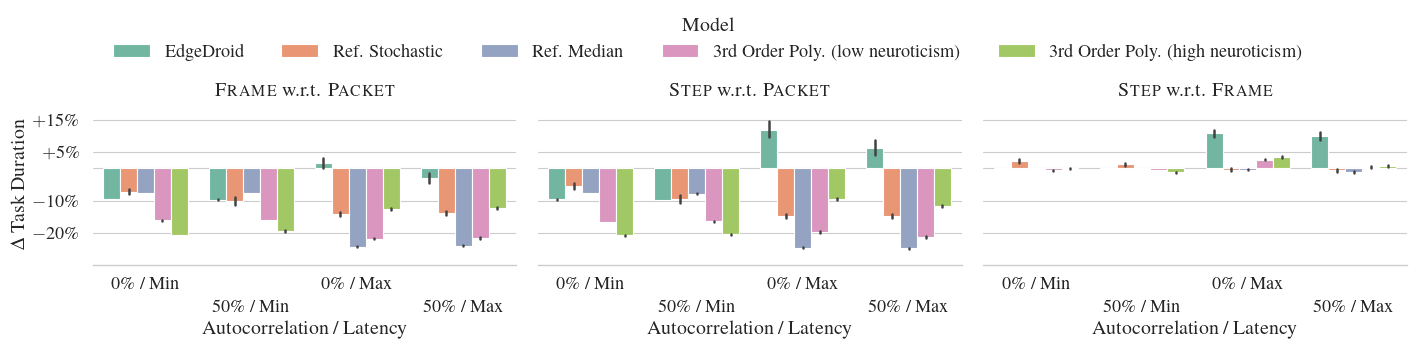

In [58]:
plot_data = task_duration_diffs.copy()
plot_data = plot_data[
    np.isin(plot_data["latency_rho"], (0.0, 0.5))
    & np.isin(plot_data.latency_mean, (0.10, 3.20))
    & np.isin(plot_data.latency_jitter, (0.02, 0.64))
    ]
for col in ("mean/jitter", "latency_rho", "latency_mean", "latency_jitter"):
    plot_data[col] = plot_data[col].cat.remove_unused_categories()

plot_data["rho_pcnt"] = plot_data["latency_rho"].apply(lambda r: r"$ " f"{r * 100.0:.0f}" r" \%$")
plot_data["latency_tag"] = plot_data["mean/jitter"].apply(lambda t: "Min" if "0.10" in t else "Max").astype(pd.CategoricalDtype(("Min", "Max"), ordered=True))
plot_data["rho/latency"] = plot_data[["rho_pcnt", "latency_tag"]].apply(lambda row: " / ".join([str(x) for x in row]), axis=1)

fg = sns.catplot(kind="bar", data=plot_data, col="comparison", hue="model", x="rho/latency", y="diff")
sns.despine(fig=fg.fig, left=True)
for ax in fg.axes.flat:
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    ax.set_yticks((-0.2, -0.1, 0, 0.1, 0.2))
    ax.yaxis.grid(True, which="both")
    # ax.yaxis.grid(True, which="major")
    # ax.xaxis.grid(True)
    ax.yaxis.set_major_formatter(lambda x, p: r"$" f"{x * 100:+.0f}" r"\% $")

fg.set_axis_labels(r"Autocorrelation / Latency", r"$ \Delta $ Task Duration")
fg.set(
    ylim=(-0.3, None),
    yticks=(-0.2, -0.1, 0.0, 0.05, 0.15),
    yticklabels=(
        r"$" f"{-0.2 * 100:+.0f}" r"\% $",
        r"$" f"{-0.1 * 100:+.0f}" r"\% $",
        "",
        r"$" f"{0.05 * 100:+.0f}" r"\% $",
        r"$" f"{0.15 * 100:+.0f}" r"\% $",
    )
)
fg.set_titles(col_template="{col_name}")
sns.move_legend(
    fg, 
    "upper center", 
    title="Model", 
    bbox_to_anchor=(.5, 1.2), 
    ncols=5
)
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 3)
fg.fig.tight_layout()
plt.savefig(PLOT_OUTPUT_DIR / "task_duration_diff_experiments.pdf", dpi=500, bbox_extra_artists=[fg.legend], bbox_inches='tight')
plt.show()